# Experiments and Results

------------------------------------

### Set up

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [40]:
import torch
from src.optimizers.SimpleTrainer import SimpleTrainer
from src.utils.evaluation import evaluate_run
from src.utils import dataset
from matplotlib import pyplot as plt
from src.optimizers import interval_narrowers
from src.optimizers.ConstrainedVolumeMultiphaseTrainer import ConstrainedVolumeMultiphaseTrainer
from src.optimizers.PGDTrainer import PGDTrainer
from src.optimizers.HypercubeTrainer import HypercubeTrainer, ConstrainedVolumeTrainer
from src.utils.evaluation import evaluate_accuracy, evaluate_fgsm_accuracy, evaluate_certified_adv_accuracy
from src.cert import Safebox
from src.optimizers.SAMTrainer import SAMTrainer
from torch.utils.data import DataLoader, Dataset
import numpy as np
import scienceplots

### Global Constants

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_RUNS = 5

### Utils

##### Plotting


In [4]:
def display_dataset(dataset):
    fig, axs = plt.subplots(1,10)
    fig.set_figwidth(15)
    for i in range(10):
        axs[i].set_axis_off()
        axs[i].imshow(dataset[i][0].numpy().reshape((28,28)), cmap="gray")

In [59]:
mnist_means_dict = {}
mnist_stds_dict = {}
fashion_mnist_means_dict = {}
fashion_mnist_stds_dict = {}

colors = ['#ff0000', '#ffa000', '#00aaff', "#00ad3a"]
markers = ['D', 'p', '*', '^']
labels= ['Adam', 'PGD','Inflate']
#labels= ['Adam', 'PGD', 'SAM', 'Inflate']

In [56]:
def plotMethod(means, stds, ax):
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.errorbar(mean, np.arange(3*(len(means)+1),0,-(len(means)+1))-i, xerr=std, fmt='none', color='black', capsize=4, elinewidth=1.5, capthick=1.5)
        ax.scatter(mean, np.arange(3*(len(means)+1),0,-(len(means)+1))-i, marker=markers[i], s=16, color=colors[i], zorder=10, label=labels[i])

    ax.legend(loc='best')
    plt.rcParams.update({'ytick.right': False})
    plt.rcParams.update({'ytick.left': False})
    ticks = []
    t_labels = []
    metrics = ['Clean', 'FGSM', 'CAA']
    
    for i in range(1, 3*(len(means)+1)+1):
        if i%(len(means)+1)!= 1 : 
            ticks.append(i)
        if i%(len(means)+1) == (len(means)+3)//2 :
            t_labels.append(metrics.pop())
        elif i%(len(means)+1)!= 1 : 
            t_labels.append('')

    ax.set_yticks(ticks, labels=t_labels)

In [41]:
plt.style.use(['science','ieee'])

##### Evaluation

In [6]:
def evaluate_model(model: torch.nn.Sequential, test_dataset: Dataset, epsilon_fgsm: float = 0.1, epsilon_cert_adv: float = 0.03, data_domain: tuple[float] = (0.0,1.0)) -> list[int]: 
    model = model.to(DEVICE)
    model.eval()
    acc = evaluate_accuracy(test_dataset, model, num_samples=len(test_dataset), device=DEVICE)
    fgsm_acc = evaluate_fgsm_accuracy(test_dataset, model, num_samples=len(test_dataset), device=DEVICE, epsilon=epsilon_fgsm, data_domain=data_domain)
    cert_acc = evaluate_certified_adv_accuracy(test_dataset, model, num_samples=len(test_dataset), data_domain=data_domain, device=DEVICE, epsilon=epsilon_cert_adv )
    return [acc, fgsm_acc, cert_acc]

##### Experiment

### Datasets

We evaluate our methodology on the following datasets : MNIST, Fashion-MNIST
##### MNIST

Digit recognition dataset. 

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 288kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.83MB/s]

Train Dataset Size:  48000
Test Dataset Size:  12000
Validation Dataset Size:  10000
Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. 


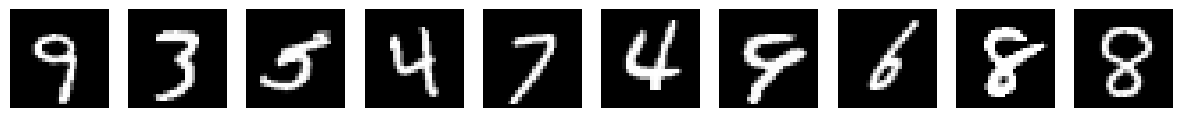

In [7]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

mnist_train_test, mnist_val = dataset.get_mnist_dataset(root="./data")
mnist_train, mnist_test = dataset.split_dataset(mnist_train_test, split_proportion=0.8)
display_dataset(mnist_train)
print("Train Dataset Size: ", len(mnist_train))
print("Test Dataset Size: ", len(mnist_test))
print("Validation Dataset Size: ", len(mnist_val))
print("Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. ")

##### FashionMNIST

Clothing classification dataset.

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 2.53MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 14.8MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 40.9MB/s]


Train Dataset Size:  48000
Test Dataset Size:  12000
Validation Dataset Size:  10000
Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. 


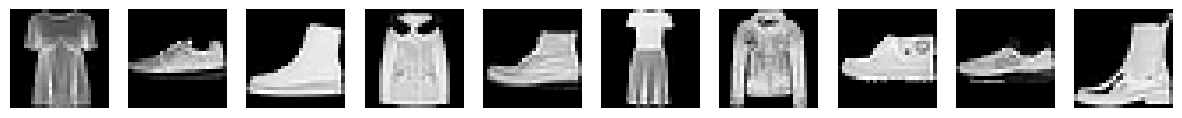

In [8]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

fashion_mnist_train_test, fashion_mnist_val = dataset.get_fashion_mnist_dataset(root="./data")
fashion_mnist_train, fashion_mnist_test = dataset.split_dataset(fashion_mnist_train_test, split_proportion=0.8)
display_dataset(fashion_mnist_train)
print("Train Dataset Size: ", len(fashion_mnist_train))
print("Test Dataset Size: ", len(fashion_mnist_test))
print("Validation Dataset Size: ", len(fashion_mnist_val))
print("Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. ")

In [8]:
X, y = next(iter(DataLoader(fashion_mnist_train, batch_size=len(fashion_mnist_train), shuffle=True)))
print(X.max())
print(X.min())
X, y = next(iter(DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=True)))
print(X.max())
print(X.min())

tensor(1.)
tensor(-1.)
tensor(1.)
tensor(-1.)


### Model definition

We use a simple 3 layer shallow network to benchmark our methodology. 

In [9]:
def get_model(output_dim=10):
    """Returns a simple CNN model."""
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(576, output_dim),
    ).to(DEVICE)
    return model

### Experiments
------------------------
### MNIST


#### Constants

In [ ]:
MNIST_EPSILON_FGSM = 0.1
MNIST_EPSILON_CERT_ADV = 0.03
MNIST_DATA_DOMAIN = (-1.0, 1.0)

ADAM = "adam"
SAM = "sam"
PGD = "pgd"
HYPERCUBE = "hypercube"

#### ADAM Baseline

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def runAdam() -> list[float]:
    adam_model = get_model()        
    trainer = SimpleTrainer(adam_model, device=DEVICE, quiet=False, acc_evaluation_steps=70)
    trainer.train(mnist_train, mnist_val, loss_obj=0.0, max_iters=700, batch_size=64, lr=1e-3)
    adam_model = trainer.result()
    return evaluate_model(adam_model, mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runAdam, N_RUNS)
print("="*10, f"Performance of Adam across {N_RUNS} independent runs", "="*10)
print(f"Clean Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"FGSM Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print(f"Certified Adversarial Accuracy : {means[2]:.4f} (std {stds[2]:.4f})")

mnist_means_dict[ADAM] = means
mnist_stds_dict[ADAM] = stds
#print("All runs : ", all_runs)

 ---------- Starting Run #0 ---------- 


100%|██████████| 700/700 [00:19<00:00, 36.62it/s, loss=0.0986, val_acc=0.916]


-> Run finished with values : [0.918666660785675, 0.7102500200271606, 0.006083333399146795]
 ---------- Starting Run #1 ---------- 


100%|██████████| 700/700 [00:18<00:00, 37.54it/s, loss=0.438, val_acc=0.921] 


-> Run finished with values : [0.9175833463668823, 0.6655833125114441, 0.052416667342185974]
 ---------- Starting Run #2 ---------- 


100%|██████████| 700/700 [00:18<00:00, 38.16it/s, loss=0.155, val_acc=0.912] 


-> Run finished with values : [0.9175833463668823, 0.7221666574478149, 0.006000000052154064]
 ---------- Starting Run #3 ---------- 


100%|██████████| 700/700 [00:18<00:00, 38.66it/s, loss=0.202, val_acc=0.924] 


-> Run finished with values : [0.9179166555404663, 0.6653333306312561, 0.03708333149552345]
 ---------- Starting Run #4 ---------- 


100%|██████████| 700/700 [00:18<00:00, 38.88it/s, loss=0.226, val_acc=0.928] 


-> Run finished with values : [0.9213333129882812, 0.7403333187103271, 0.07750000059604645]
========== Performance of Adam across 5 independent runs ==========
Clean Accuracy : 0.9186 (std 0.0016)
FGSM Accuracy : 0.7007 (std 0.0339)
Certified Adversarial Accuracy : 0.0358 (std 0.0308)


#### PGD Baseline

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
# optimal parameters borrowed from https://github.com/MadryLab/mnist_challenge/blob/master/config.json
# epsilon was reduced to 0.2 to allow for training. We noticed that epsilon=0.3 consistently did not train across 10 independant runs. This is because we use a smaller architecture here. 
def runPGD() -> list[float]:
    restart = True
    trainer = None 
    while restart: # restarts if bad initialization is detected
        pgd_model = get_model()        
        trainer = PGDTrainer(pgd_model, quiet=False, device=DEVICE)
        restart = not trainer.train(
            mnist_train, mnist_val, 0.0, max_iters=700, batch_size=64, lr=1e-3, epsilon=0.3, alpha=0.01, num_iters=40, data_domain=MNIST_DATA_DOMAIN
        )
    pgd_model = trainer.result()
    return evaluate_model(pgd_model, mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runPGD, N_RUNS)
print("="*10, f"Performance of PGD across {N_RUNS} independent runs", "="*10)
print(f"Clean Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"FGSM Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print(f"Certified Adversarial Accuracy : {means[2]:.4f} (std {stds[2]:.4f})")

mnist_means_dict[PGD] = means
mnist_stds_dict[PGD] = stds
#print("All runs : ", all_runs)

 ---------- Starting Run #0 ---------- 


 14%|█▍        | 101/700 [00:05<00:31, 18.97it/s, loss=2.3, val_acc=0.0781]


Bad Initialization detected. Interrupted Training.


100%|██████████| 700/700 [00:36<00:00, 19.26it/s, loss=0.625, val_acc=0.938]


-> Run finished with values : [0.9039999842643738, 0.8759999871253967, 0.8243333101272583]
 ---------- Starting Run #1 ---------- 


 14%|█▍        | 101/700 [00:05<00:30, 19.43it/s, loss=2.3, val_acc=0.0781] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.05it/s, loss=2.3, val_acc=0.141] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 18.96it/s, loss=2.3, val_acc=0.188] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.04it/s, loss=2.3, val_acc=0.109] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.55it/s, loss=2.3, val_acc=0.0625]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.44it/s, loss=2.3, val_acc=0.141] 


Bad Initialization detected. Interrupted Training.


100%|██████████| 700/700 [00:35<00:00, 19.59it/s, loss=0.668, val_acc=0.969]


-> Run finished with values : [0.9018332958221436, 0.8729166388511658, 0.5953333377838135]
 ---------- Starting Run #2 ---------- 


 14%|█▍        | 101/700 [00:05<00:31, 19.07it/s, loss=2.31, val_acc=0.156] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:32, 18.33it/s, loss=2.3, val_acc=0.109] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 18.83it/s, loss=2.3, val_acc=0.156] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.52it/s, loss=2.3, val_acc=0.109] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.43it/s, loss=2.3, val_acc=0.156] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.48it/s, loss=2.31, val_acc=0.109]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.51it/s, loss=2.3, val_acc=0.0938]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.37it/s, loss=2.3, val_acc=0.0938]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.41it/s, loss=2.3, val_acc=0.0938]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.32it/s, loss=2.3, val_acc=0.0781]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.30it/s, loss=2.3, val_acc=0.0625]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.36it/s, loss=2.3, val_acc=0.0625]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.43it/s, loss=2.3, val_acc=0.125]  


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.39it/s, loss=2.3, val_acc=0.172] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.26it/s, loss=2.3, val_acc=0.0938]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.30it/s, loss=2.3, val_acc=0.125] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.00it/s, loss=2.3, val_acc=0.156] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.24it/s, loss=2.31, val_acc=0.0781]


Bad Initialization detected. Interrupted Training.


100%|██████████| 700/700 [00:36<00:00, 19.33it/s, loss=0.916, val_acc=0.875]


-> Run finished with values : [0.8943333029747009, 0.8588333129882812, 0.5293333530426025]
 ---------- Starting Run #3 ---------- 


 14%|█▍        | 101/700 [00:05<00:30, 19.49it/s, loss=2.3, val_acc=0.0625]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.26it/s, loss=2.3, val_acc=0.0469]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.39it/s, loss=2.3, val_acc=0.0625] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.44it/s, loss=2.3, val_acc=0.0938]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.37it/s, loss=2.3, val_acc=0.0938]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.43it/s, loss=2.31, val_acc=0.125]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.50it/s, loss=2.3, val_acc=0.125] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.34it/s, loss=2.3, val_acc=0.141] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.45it/s, loss=2.3, val_acc=0.141] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.32it/s, loss=2.3, val_acc=0.188] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:30, 19.34it/s, loss=2.3, val_acc=0.141] 


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.15it/s, loss=2.3, val_acc=0.0312]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.20it/s, loss=2.3, val_acc=0.0938] 


Bad Initialization detected. Interrupted Training.


100%|██████████| 700/700 [00:35<00:00, 19.48it/s, loss=0.781, val_acc=0.906]


-> Run finished with values : [0.8942499756813049, 0.8577499985694885, 0.4607499837875366]
 ---------- Starting Run #4 ---------- 


 14%|█▍        | 101/700 [00:05<00:30, 19.40it/s, loss=2.3, val_acc=0.0625]


Bad Initialization detected. Interrupted Training.


 14%|█▍        | 101/700 [00:05<00:31, 19.31it/s, loss=2.3, val_acc=0.172] 


Bad Initialization detected. Interrupted Training.


100%|██████████| 700/700 [00:35<00:00, 19.65it/s, loss=0.596, val_acc=0.875]


-> Run finished with values : [0.8964999914169312, 0.8690833449363708, 0.6859999895095825]
========== Performance of PGD across 5 independent runs ==========
Clean Accuracy : 0.8982 (std 0.0045)
FGSM Accuracy : 0.8669 (std 0.0083)
Certified Adversarial Accuracy : 0.6191 (std 0.1417)


#### Hypercube Training (Ours)

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def runHypercube() -> list[float]:
    h_model = None
    optimizer = None 
    multiphase_trainer = None 
    restart = True 
    while restart: # Restarts if bad initialization leads to no convergences at beginning of training (doesn't happen very often)
        h_model = get_model(output_dim=10)
        optimizer = HypercubeTrainer(h_model, device=DEVICE)
        multiphase_trainer = ConstrainedVolumeMultiphaseTrainer(
            optimizer, 
            inflate_function=interval_narrowers.inflate_multiplier(2.0),
            narrow_function=interval_narrowers.narrower_halver(0.5),
            starting_value=1e-4*0.5, 
            min_acc_limit=0.78,
            quiet=False
        )
        restart = not multiphase_trainer.train(
            7, mnist_val,
            mnist_train, mnist_val, loss_obj=0.0, max_iters=100, batch_size=64, lr=1e-3
        )
    h_model = Safebox.bmodelToModel(multiphase_trainer.result()) # evaluate center model 
    return evaluate_model(h_model, mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runHypercube, N_RUNS)
print("="*10, f"Performance of Hypercube training across {N_RUNS} independent runs", "="*10)
print(f"Clean Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"FGSM Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print(f"Certified Adversarial Accuracy : {means[2]:.4f} (std {stds[2]:.4f})")

mnist_means_dict[HYPERCUBE] = means
mnist_stds_dict[HYPERCUBE] = stds
#print("All runs : ", all_runs)

 ---------- Starting Run #0 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 36.95it/s, loss=0.734, min_val_acc=0.819]


=> Initial center accuracy is 0.8600000143051147
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 37.00it/s, loss=0.268, min_val_acc=0.875]


-> Phase done
-> Center Accuracy is 0.8901000022888184.
-> Generalization is above minimum accuracy by 0.11010000228881833.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 36.80it/s, loss=0.536, min_val_acc=0.869]


-> Phase done
-> Center Accuracy is 0.9007999897003174.
-> Generalization is above minimum accuracy by 0.12079998970031736.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 37.44it/s, loss=0.478, min_val_acc=0.851]


-> Phase done
-> Center Accuracy is 0.9128999710083008.
-> Generalization is above minimum accuracy by 0.13289997100830075.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.24it/s, loss=0.8, min_val_acc=0.817] 


-> Phase done
-> Center Accuracy is 0.9139000177383423.
-> Generalization is above minimum accuracy by 0.13390001773834226.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 37.08it/s, loss=0.853, min_val_acc=0.754]


-> Phase done
-> Center Accuracy is 0.9142000079154968.
-> Generalization is above minimum accuracy by 0.1342000079154968.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 38.09it/s, loss=1.36, min_val_acc=0.581]


-> Phase done
-> Center Accuracy is 0.9016000032424927.
-> Generalization is above minimum accuracy by 0.12160000324249265.!
Training succeeded !
-> Run finished with values : [0.8921666741371155, 0.8032500147819519, 0.8134999871253967]
 ---------- Starting Run #1 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 36.63it/s, loss=0.396, min_val_acc=0.845]


=> Initial center accuracy is 0.8539999723434448
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 36.90it/s, loss=0.238, min_val_acc=0.89]


-> Phase done
-> Center Accuracy is 0.897599995136261.
-> Generalization is above minimum accuracy by 0.11759999513626096.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 38.87it/s, loss=0.664, min_val_acc=0.875]


-> Phase done
-> Center Accuracy is 0.9075999855995178.
-> Generalization is above minimum accuracy by 0.1275999855995178.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 39.45it/s, loss=0.457, min_val_acc=0.857]


-> Phase done
-> Center Accuracy is 0.9106000065803528.
-> Generalization is above minimum accuracy by 0.13060000658035276.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 43.68it/s, loss=0.459, min_val_acc=0.834]


-> Phase done
-> Center Accuracy is 0.9162999987602234.
-> Generalization is above minimum accuracy by 0.13629999876022336.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 39.42it/s, loss=0.814, min_val_acc=0.778]


-> Phase done
-> Center Accuracy is 0.9161999821662903.
-> Generalization is above minimum accuracy by 0.13619998216629026.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 39.65it/s, loss=1.82, min_val_acc=0.588]


-> Phase done
-> Center Accuracy is 0.9085000157356262.
-> Generalization is above minimum accuracy by 0.1285000157356262.!
Training succeeded !
-> Run finished with values : [0.8999166488647461, 0.812749981880188, 0.8196666836738586]
 ---------- Starting Run #2 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 40.96it/s, loss=0.798, min_val_acc=0.7] 


=> Initial center accuracy is 0.8535000085830688
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 39.39it/s, loss=0.737, min_val_acc=0.885]


-> Phase done
-> Center Accuracy is 0.904699981212616.
-> Generalization is above minimum accuracy by 0.12469998121261594.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 39.55it/s, loss=0.332, min_val_acc=0.893]


-> Phase done
-> Center Accuracy is 0.9172999858856201.
-> Generalization is above minimum accuracy by 0.1372999858856201.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 37.85it/s, loss=0.505, min_val_acc=0.875]


-> Phase done
-> Center Accuracy is 0.9222000241279602.
-> Generalization is above minimum accuracy by 0.14220002412796018.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 44.41it/s, loss=0.485, min_val_acc=0.838]


-> Phase done
-> Center Accuracy is 0.9243000149726868.
-> Generalization is above minimum accuracy by 0.14430001497268674.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 39.96it/s, loss=0.984, min_val_acc=0.744]


-> Phase done
-> Center Accuracy is 0.9218999743461609.
-> Generalization is above minimum accuracy by 0.14189997434616086.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.06it/s, loss=1.53, min_val_acc=0.577]


-> Phase done
-> Center Accuracy is 0.9004999995231628.
-> Generalization is above minimum accuracy by 0.12049999952316282.!
Training succeeded !
-> Run finished with values : [0.8961666822433472, 0.7993333339691162, 0.8066666722297668]
 ---------- Starting Run #3 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 40.46it/s, loss=0.359, min_val_acc=0.836]


=> Initial center accuracy is 0.8736000061035156
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 39.82it/s, loss=0.533, min_val_acc=0.876]


-> Phase done
-> Center Accuracy is 0.9082000255584717.
-> Generalization is above minimum accuracy by 0.12820002555847165.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 38.44it/s, loss=0.472, min_val_acc=0.883]


-> Phase done
-> Center Accuracy is 0.9233999848365784.
-> Generalization is above minimum accuracy by 0.14339998483657834.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.27it/s, loss=0.441, min_val_acc=0.875]


-> Phase done
-> Center Accuracy is 0.9204999804496765.
-> Generalization is above minimum accuracy by 0.1404999804496765.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 44.24it/s, loss=0.311, min_val_acc=0.848]


-> Phase done
-> Center Accuracy is 0.928600013256073.
-> Generalization is above minimum accuracy by 0.14860001325607297.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.22it/s, loss=0.945, min_val_acc=0.791]


-> Phase done
-> Center Accuracy is 0.923799991607666.
-> Generalization is above minimum accuracy by 0.143799991607666.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.24it/s, loss=0.976, min_val_acc=0.656]


-> Phase done
-> Center Accuracy is 0.9107000231742859.
-> Generalization is above minimum accuracy by 0.13070002317428586.!
Training succeeded !
-> Run finished with values : [0.9004999995231628, 0.8189166784286499, 0.828000009059906]
 ---------- Starting Run #4 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 40.04it/s, loss=2.3, min_val_acc=0.114]


=> Initial center accuracy is 0.11349999904632568
Initial accuracy is below min accuracy threshold by 0.6665000009536743. Training failed.
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 40.17it/s, loss=2.3, min_val_acc=0.103]


=> Initial center accuracy is 0.10090000182390213
Initial accuracy is below min accuracy threshold by 0.6790999981760979. Training failed.
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 39.97it/s, loss=2.31, min_val_acc=0.0915]


=> Initial center accuracy is 0.10100000351667404
Initial accuracy is below min accuracy threshold by 0.678999996483326. Training failed.
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 100/100 [00:02<00:00, 40.01it/s, loss=0.362, min_val_acc=0.83]


=> Initial center accuracy is 0.8708000183105469
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.10it/s, loss=0.259, min_val_acc=0.899]


-> Phase done
-> Center Accuracy is 0.9104999899864197.
-> Generalization is above minimum accuracy by 0.13049998998641965.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.10it/s, loss=0.304, min_val_acc=0.909]


-> Phase done
-> Center Accuracy is 0.9251000285148621.
-> Generalization is above minimum accuracy by 0.14510002851486203.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.18it/s, loss=0.75, min_val_acc=0.902]


-> Phase done
-> Center Accuracy is 0.9333999752998352.
-> Generalization is above minimum accuracy by 0.15339997529983518.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 43.47it/s, loss=0.622, min_val_acc=0.873]


-> Phase done
-> Center Accuracy is 0.933899998664856.
-> Generalization is above minimum accuracy by 0.15389999866485593.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 40.12it/s, loss=0.73, min_val_acc=0.839]


-> Phase done
-> Center Accuracy is 0.9284999966621399.
-> Generalization is above minimum accuracy by 0.14849999666213987.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 100/100 [00:02<00:00, 38.11it/s, loss=0.972, min_val_acc=0.717]


-> Phase done
-> Center Accuracy is 0.9211999773979187.
-> Generalization is above minimum accuracy by 0.14119997739791867.!
Training succeeded !
-> Run finished with values : [0.9099999666213989, 0.8229166865348816, 0.8308333158493042]
========== Performance of Hypercube training across 5 independent runs ==========
Clean Accuracy : 0.8997 (std 0.0066)
FGSM Accuracy : 0.8114 (std 0.0100)
Certified Adversarial Accuracy : 0.8197 (std 0.0100)


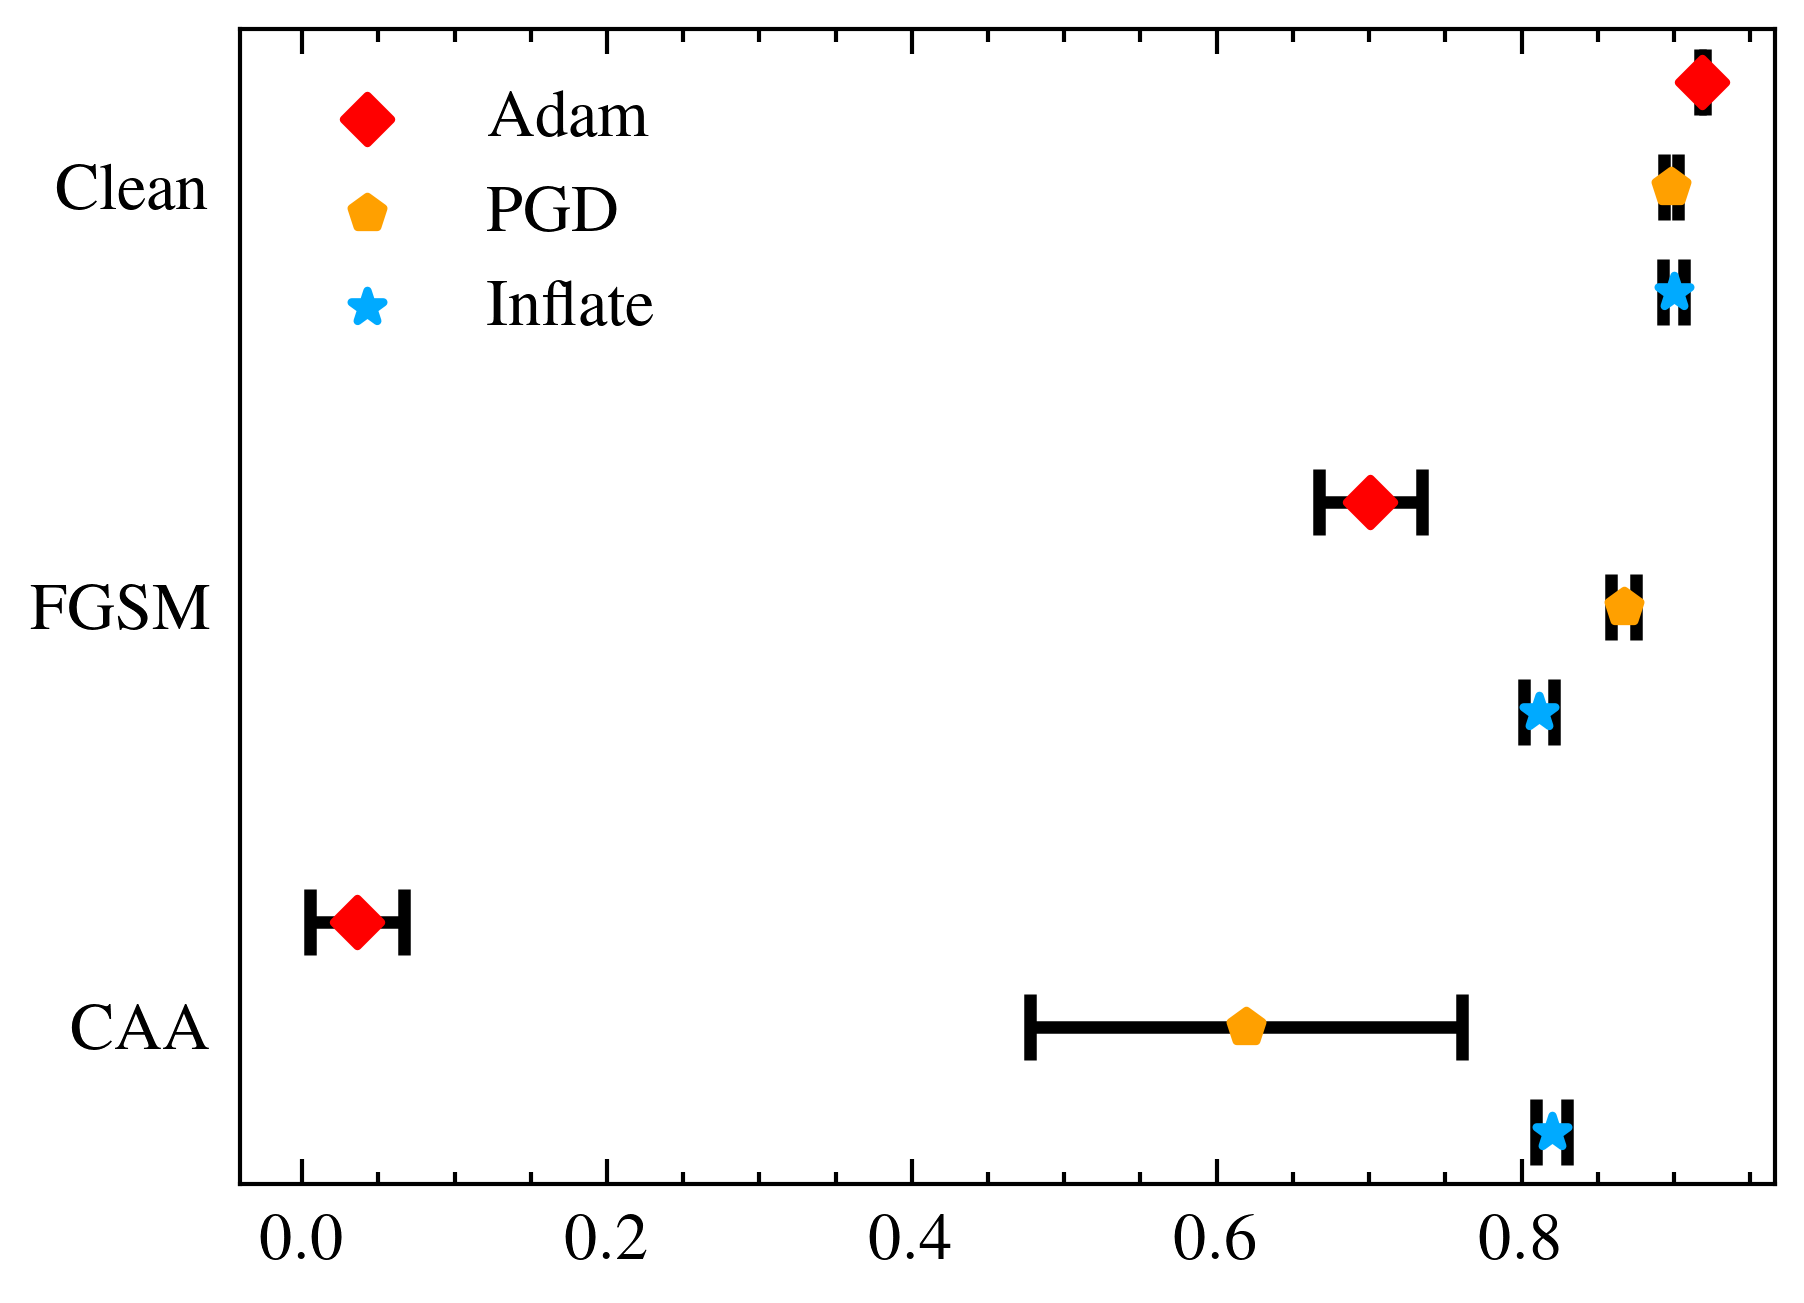

In [ ]:
fig, ax = plt.subplots()
plotMethod(
    [mnist_means_dict[ADAM], mnist_means_dict[PGD], mnist_means_dict[HYPERCUBE]],
    [mnist_stds_dict[ADAM], mnist_stds_dict[PGD], mnist_stds_dict[HYPERCUBE]],
    #[mnist_means_dict[ADAM], mnist_means_dict[PGD], mnist_means_dict[SAM], mnist_means_dict[HYPERCUBE]],
    #[mnist_stds_dict[ADAM], mnist_stds_dict[PGD], mnist_stds_dict[SAM],  mnist_stds_dict[HYPERCUBE]],
    ax
    )

### Fashion-MNIST

#### ADAM Baseline

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def runAdam() -> list[float]:
    restart = True 
    trainer = None 
    while restart:
        adam_model = get_model()        
        trainer = SimpleTrainer(adam_model, device=DEVICE, quiet=False, acc_evaluation_steps=200)
        restart = not trainer.train(fashion_mnist_train, fashion_mnist_val, loss_obj=0.0, max_iters=7000, batch_size=64, lr=1e-3)
    adam_model = trainer.result()
    return evaluate_model(adam_model, fashion_mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runAdam, N_RUNS)
print("="*10, f"Performance of Adam across {N_RUNS} independent runs", "="*10)
print(f"Clean Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"FGSM Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print(f"Certified Adversarial Accuracy : {means[2]:.4f} (std {stds[2]:.4f})")

fashion_mnist_means_dict[ADAM] = means
fashion_mnist_stds_dict[ADAM] = stds

#print("All runs : ", all_runs)

 ---------- Starting Run #0 ---------- 


100%|██████████| 7000/7000 [03:08<00:00, 37.07it/s, loss=0.484, val_acc=0.858]


-> Run finished with values : [0.8647499680519104, 0.140666663646698, 0.0]
 ---------- Starting Run #1 ---------- 


100%|██████████| 7000/7000 [03:09<00:00, 37.04it/s, loss=0.326, val_acc=0.869]


-> Run finished with values : [0.8729999661445618, 0.10266666859388351, 0.0]
 ---------- Starting Run #2 ---------- 


100%|██████████| 7000/7000 [03:08<00:00, 37.09it/s, loss=0.261, val_acc=0.859]


-> Run finished with values : [0.85916668176651, 0.19741666316986084, 0.0]
 ---------- Starting Run #3 ---------- 


100%|██████████| 7000/7000 [03:10<00:00, 36.66it/s, loss=0.703, val_acc=0.856]


-> Run finished with values : [0.8571666479110718, 0.132833331823349, 0.0]
 ---------- Starting Run #4 ---------- 


100%|██████████| 7000/7000 [03:09<00:00, 36.99it/s, loss=0.291, val_acc=0.864] 


-> Run finished with values : [0.8646666407585144, 0.18050000071525574, 0.0]
========== Performance of Adam across 5 independent runs ==========
Clean Accuracy : 0.8637 (std 0.0062)
FGSM Accuracy : 0.1508 (std 0.0381)
Certified Adversarial Accuracy : 0.0000 (std 0.0000)


#### PGD Baseline

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def runPGD() -> list[float]:
    restart = True
    trainer = None 
    while restart: # restarts if bad initialization is detected
        pgd_model = get_model()        
        trainer = PGDTrainer(pgd_model, quiet=False, device=DEVICE)
        restart = not trainer.train(
            fashion_mnist_train, fashion_mnist_val, 0.0, max_iters=7000, batch_size=64, lr=1e-3, epsilon=0.3, alpha=0.01, num_iters=40, data_domain=MNIST_DATA_DOMAIN
        )
    pgd_model = trainer.result()
    return evaluate_model(pgd_model, fashion_mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runPGD, N_RUNS)
print("="*10, f"Performance of PGD across {N_RUNS} independent runs", "="*10)
print(f"Clean Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"FGSM Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print(f"Certified Adversarial Accuracy : {means[2]:.4f} (std {stds[2]:.4f})")

fashion_mnist_means_dict[PGD] = means
fashion_mnist_stds_dict[PGD] = stds
#print("All runs : ", all_runs)

 ---------- Starting Run #0 ---------- 


  1%|▏         | 101/7000 [00:10<11:46,  9.76it/s, loss=2.3, val_acc=0.141] 


BAd Initialization detected. Interrupted Training.


100%|██████████| 7000/7000 [11:50<00:00,  9.85it/s, loss=0.933, val_acc=0.75] 


-> Run finished with values : [0.7665833234786987, 0.7307499647140503, 0.23549999296665192]
 ---------- Starting Run #1 ---------- 


  1%|▏         | 101/7000 [00:10<11:40,  9.85it/s, loss=2.3, val_acc=0.109] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:40,  9.85it/s, loss=2.3, val_acc=0.0938] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:44,  9.79it/s, loss=2.3, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:51,  9.70it/s, loss=2.3, val_acc=0.0781]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:12<14:24,  7.98it/s, loss=2.31, val_acc=0.0781]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<12:22,  9.29it/s, loss=2.31, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:38,  9.87it/s, loss=2.3, val_acc=0.0781]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:43,  9.81it/s, loss=2.3, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:36,  9.90it/s, loss=2.3, val_acc=0.109] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:28, 10.02it/s, loss=2.3, val_acc=0.141] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:41,  9.84it/s, loss=2.3, val_acc=0.0781]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<12:16,  9.37it/s, loss=2.3, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


100%|██████████| 7000/7000 [11:51<00:00,  9.84it/s, loss=0.821, val_acc=0.797]


-> Run finished with values : [0.7598333358764648, 0.7224999666213989, 0.2835833430290222]
 ---------- Starting Run #2 ---------- 


  1%|▏         | 101/7000 [00:10<11:47,  9.75it/s, loss=2.31, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:34,  9.93it/s, loss=2.31, val_acc=0.0781]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:44,  9.79it/s, loss=2.3, val_acc=0.0938] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:47,  9.76it/s, loss=2.3, val_acc=0.109] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:44,  9.79it/s, loss=2.3, val_acc=0.0469]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:41,  9.84it/s, loss=2.31, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:47,  9.75it/s, loss=2.31, val_acc=0.0781]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:30,  9.99it/s, loss=2.31, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:34,  9.93it/s, loss=2.3, val_acc=0.125] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:42,  9.82it/s, loss=2.3, val_acc=0.0625] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:37,  9.89it/s, loss=2.3, val_acc=0.109] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:36,  9.91it/s, loss=2.3, val_acc=0.0625] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:44,  9.79it/s, loss=2.3, val_acc=0.0938]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:48,  9.73it/s, loss=2.3, val_acc=0.109] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:42,  9.82it/s, loss=2.3, val_acc=0.125] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:37,  9.89it/s, loss=2.3, val_acc=0.0781]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:40,  9.84it/s, loss=2.3, val_acc=0.125]  


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<11:41,  9.84it/s, loss=2.3, val_acc=0.125] 


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:11<13:10,  8.73it/s, loss=2.3, val_acc=0.109] 


BAd Initialization detected. Interrupted Training.


100%|██████████| 7000/7000 [11:48<00:00,  9.88it/s, loss=0.79, val_acc=0.703] 


-> Run finished with values : [0.7392500042915344, 0.6987500190734863, 0.2055833339691162]
 ---------- Starting Run #3 ---------- 


100%|██████████| 7000/7000 [11:52<00:00,  9.83it/s, loss=0.815, val_acc=0.625]


-> Run finished with values : [0.7517499923706055, 0.7119166851043701, 0.12258332967758179]
 ---------- Starting Run #4 ---------- 


  1%|▏         | 101/7000 [00:10<12:09,  9.46it/s, loss=2.31, val_acc=0.0312]


BAd Initialization detected. Interrupted Training.


  1%|▏         | 101/7000 [00:10<12:01,  9.56it/s, loss=2.3, val_acc=0.141] 


BAd Initialization detected. Interrupted Training.


100%|██████████| 7000/7000 [12:09<00:00,  9.60it/s, loss=0.793, val_acc=0.75] 


-> Run finished with values : [0.7672500014305115, 0.7305833101272583, 0.1929166615009308]
========== Performance of PGD across 5 independent runs ==========
Clean Accuracy : 0.7569 (std 0.0117)
FGSM Accuracy : 0.7189 (std 0.0136)
Certified Adversarial Accuracy : 0.2080 (std 0.0592)


#### Hypercube Training (Ours)

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def runHypercube() -> list[float]:
    h_model = None
    optimizer = None 
    multiphase_trainer = None 
    restart = True 
    while restart: # Restarts if bad initialization leads to no convergences at beginning of training (doesn't happen very often)
        h_model = get_model(output_dim=10)
        optimizer = HypercubeTrainer(h_model, device=DEVICE)
        multiphase_trainer = ConstrainedVolumeMultiphaseTrainer(
            optimizer, 
            inflate_function=interval_narrowers.inflate_multiplier(2.0),
            narrow_function=interval_narrowers.narrower_halver(0.5),
            starting_value=1e-4*0.5, 
            min_acc_limit=0.78,
            quiet=False
        )
        restart = not multiphase_trainer.train(
            7, fashion_mnist_val,
            fashion_mnist_train, fashion_mnist_val, loss_obj=0.0, max_iters=1000, batch_size=64, lr=1e-3
        )
    h_model = Safebox.bmodelToModel(multiphase_trainer.result()) # evaluate center model 
    return evaluate_model(h_model, fashion_mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runHypercube, N_RUNS)
print("="*10, f"Performance of Hypercube training across {N_RUNS} independent runs", "="*10)
print(f"Clean Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"FGSM Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print(f"Certified Adversarial Accuracy : {means[2]:.4f} (std {stds[2]:.4f})")

fashion_mnist_means_dict[HYPERCUBE] = means
fashion_mnist_stds_dict[HYPERCUBE] = stds
#print("All runs : ", all_runs)

 ---------- Starting Run #0 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 1000/1000 [00:43<00:00, 23.19it/s, loss=0.516, min_val_acc=0.806]


=> Initial center accuracy is 0.8205999732017517
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 1000/1000 [00:44<00:00, 22.50it/s, loss=0.569, min_val_acc=0.803]


-> Phase done
-> Center Accuracy is 0.8310999870300293.
-> Generalization is above minimum accuracy by 0.05109998703002927.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 1000/1000 [00:45<00:00, 22.21it/s, loss=0.556, min_val_acc=0.787]


-> Phase done
-> Center Accuracy is 0.8263999819755554.
-> Generalization is above minimum accuracy by 0.04639998197555539.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 1000/1000 [00:43<00:00, 22.77it/s, loss=0.616, min_val_acc=0.786]


-> Phase done
-> Center Accuracy is 0.8345999717712402.
-> Generalization is above minimum accuracy by 0.05459997177124021.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 1000/1000 [00:44<00:00, 22.55it/s, loss=0.295, min_val_acc=0.74]


-> Phase done
-> Center Accuracy is 0.8240000009536743.
-> Generalization is above minimum accuracy by 0.04400000095367429.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 1000/1000 [00:44<00:00, 22.39it/s, loss=0.869, min_val_acc=0.728]


-> Phase done
-> Center Accuracy is 0.8258000016212463.
-> Generalization is above minimum accuracy by 0.04580000162124631.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 1000/1000 [00:44<00:00, 22.45it/s, loss=1.13, min_val_acc=0.675]


-> Phase done
-> Center Accuracy is 0.8120999932289124.
-> Generalization is above minimum accuracy by 0.03209999322891233.!
Training succeeded !
-> Run finished with values : [0.8140000104904175, 0.5650833249092102, 0.6104999780654907]
 ---------- Starting Run #1 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


 10%|█         | 101/1000 [00:04<00:40, 22.03it/s, loss=2.3, min_val_acc=0.0985] 


BAd Initialization detected. Interrupted Training.
=> Initial center accuracy is 0.10019999742507935
Initial accuracy is below min accuracy threshold by 0.6798000025749207. Training failed.
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 1000/1000 [00:43<00:00, 22.83it/s, loss=0.421, min_val_acc=0.789]


=> Initial center accuracy is 0.8037999868392944
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 1000/1000 [00:44<00:00, 22.69it/s, loss=0.387, min_val_acc=0.8] 


-> Phase done
-> Center Accuracy is 0.8241000175476074.
-> Generalization is above minimum accuracy by 0.044100017547607395.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 1000/1000 [00:44<00:00, 22.61it/s, loss=0.411, min_val_acc=0.802]


-> Phase done
-> Center Accuracy is 0.8374000191688538.
-> Generalization is above minimum accuracy by 0.05740001916885373.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 1000/1000 [00:48<00:00, 20.47it/s, loss=0.345, min_val_acc=0.792]


-> Phase done
-> Center Accuracy is 0.8359000086784363.
-> Generalization is above minimum accuracy by 0.05590000867843625.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 1000/1000 [00:45<00:00, 22.13it/s, loss=0.419, min_val_acc=0.767]


-> Phase done
-> Center Accuracy is 0.8384000062942505.
-> Generalization is above minimum accuracy by 0.05840000629425046.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 1000/1000 [00:44<00:00, 22.70it/s, loss=0.731, min_val_acc=0.753]


-> Phase done
-> Center Accuracy is 0.8291000127792358.
-> Generalization is above minimum accuracy by 0.04910001277923581.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 1000/1000 [00:43<00:00, 23.24it/s, loss=1.11, min_val_acc=0.678]


-> Phase done
-> Center Accuracy is 0.8166999816894531.
-> Generalization is above minimum accuracy by 0.0366999816894531.!
Training succeeded !
-> Run finished with values : [0.8232499957084656, 0.6159999966621399, 0.6704166531562805]
 ---------- Starting Run #2 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 1000/1000 [00:42<00:00, 23.65it/s, loss=0.434, min_val_acc=0.817]


=> Initial center accuracy is 0.8248999714851379
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.55it/s, loss=0.431, min_val_acc=0.816]


-> Phase done
-> Center Accuracy is 0.83160001039505.
-> Generalization is above minimum accuracy by 0.05160001039505002.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.68it/s, loss=0.631, min_val_acc=0.803]


-> Phase done
-> Center Accuracy is 0.8424000144004822.
-> Generalization is above minimum accuracy by 0.06240001440048215.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s, loss=0.554, min_val_acc=0.803]


-> Phase done
-> Center Accuracy is 0.8370000123977661.
-> Generalization is above minimum accuracy by 0.05700001239776609.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 1000/1000 [00:43<00:00, 23.14it/s, loss=0.637, min_val_acc=0.783]


-> Phase done
-> Center Accuracy is 0.8317999839782715.
-> Generalization is above minimum accuracy by 0.05179998397827146.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 1000/1000 [00:43<00:00, 22.80it/s, loss=0.627, min_val_acc=0.719]


-> Phase done
-> Center Accuracy is 0.8237000107765198.
-> Generalization is above minimum accuracy by 0.04370001077651975.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 1000/1000 [00:43<00:00, 23.19it/s, loss=0.954, min_val_acc=0.666]


-> Phase done
-> Center Accuracy is 0.8104000091552734.
-> Generalization is above minimum accuracy by 0.03040000915527341.!
Training succeeded !
-> Run finished with values : [0.815750002861023, 0.6050833463668823, 0.671916663646698]
 ---------- Starting Run #3 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 1000/1000 [00:42<00:00, 23.72it/s, loss=0.567, min_val_acc=0.812]


=> Initial center accuracy is 0.8284000158309937
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.39it/s, loss=0.483, min_val_acc=0.801]


-> Phase done
-> Center Accuracy is 0.8374999761581421.
-> Generalization is above minimum accuracy by 0.05749997615814206.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.59it/s, loss=0.356, min_val_acc=0.819]


-> Phase done
-> Center Accuracy is 0.8292999863624573.
-> Generalization is above minimum accuracy by 0.04929998636245725.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.46it/s, loss=0.411, min_val_acc=0.787]


-> Phase done
-> Center Accuracy is 0.836899995803833.
-> Generalization is above minimum accuracy by 0.05689999580383298.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s, loss=0.723, min_val_acc=0.767]


-> Phase done
-> Center Accuracy is 0.829800009727478.
-> Generalization is above minimum accuracy by 0.049800009727478.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.32it/s, loss=0.588, min_val_acc=0.739]


-> Phase done
-> Center Accuracy is 0.822700023651123.
-> Generalization is above minimum accuracy by 0.04270002365112302.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.34it/s, loss=0.863, min_val_acc=0.685]


-> Phase done
-> Center Accuracy is 0.8086000084877014.
-> Generalization is above minimum accuracy by 0.02860000848770139.!
Training succeeded !
-> Run finished with values : [0.8103333115577698, 0.5834999680519104, 0.6380833387374878]
 ---------- Starting Run #4 ---------- 
========== Started Multiphase Trainer for 7 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 1000/1000 [00:42<00:00, 23.44it/s, loss=0.535, min_val_acc=0.815]


=> Initial center accuracy is 0.8162999749183655
-> Starting phase 6
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.34it/s, loss=0.472, min_val_acc=0.823]


-> Phase done
-> Center Accuracy is 0.8334000110626221.
-> Generalization is above minimum accuracy by 0.053400011062622044.!
-> Starting phase 6
-> Current Volume interval : [0.0001, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.34it/s, loss=0.367, min_val_acc=0.796]


-> Phase done
-> Center Accuracy is 0.8360000252723694.
-> Generalization is above minimum accuracy by 0.05600002527236936.!
-> Starting phase 6
-> Current Volume interval : [0.0002, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.45it/s, loss=0.507, min_val_acc=0.778]


-> Phase done
-> Center Accuracy is 0.8352000117301941.
-> Generalization is above minimum accuracy by 0.055200011730194065.!
-> Starting phase 6
-> Current Volume interval : [0.0004, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.35it/s, loss=0.57, min_val_acc=0.734]


-> Phase done
-> Center Accuracy is 0.8294000029563904.
-> Generalization is above minimum accuracy by 0.049400002956390354.!
-> Starting phase 6
-> Current Volume interval : [0.0008, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.42it/s, loss=0.45, min_val_acc=0.721]


-> Phase done
-> Center Accuracy is 0.8205000162124634.
-> Generalization is above minimum accuracy by 0.04050001621246335.!
-> Starting phase 6
-> Current Volume interval : [0.0016, INFINITY]


100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s, loss=0.71, min_val_acc=0.686]


-> Phase done
-> Center Accuracy is 0.8126999735832214.
-> Generalization is above minimum accuracy by 0.03269997358322141.!
Training succeeded !
-> Run finished with values : [0.8140833377838135, 0.5790833234786987, 0.6517499685287476]
========== Performance of Hypercube training across 5 independent runs ==========
Clean Accuracy : 0.8155 (std 0.0048)
FGSM Accuracy : 0.5897 (std 0.0205)
Certified Adversarial Accuracy : 0.6485 (std 0.0255)


In [ ]:
fig, ax = plt.subplots()
plotMethod(
    [fashion_mnist_means_dict[ADAM], fashion_mnist_means_dict[PGD], fashion_mnist_means_dict[HYPERCUBE]],
    [fashion_mnist_stds_dict[ADAM], fashion_mnist_stds_dict[PGD], fashion_mnist_stds_dict[HYPERCUBE]],
    #[fashion_mnist_means_dict[ADAM], fashion_mnist_means_dict[PGD], fashion_mnist_means_dict[SAM], fashion_mnist_means_dict[HYPERCUBE]],
    #[fashion_mnist_stds_dict[ADAM],  fashion_mnist_stds_dict[PGD], fashion_mnist_stds_dict[SAM], fashion_mnist_stds_dict[HYPERCUBE]],
    ax
    )